In [1]:
import torch
import torchvision
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
trainset = datasets.CIFAR10('cifar',
            train=True, download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
            ]))

Files already downloaded and verified


In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Create a dataset
trainset = datasets.CIFAR10('cifar',
                            train=True, download=True,
                            transform=transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.ToTensor()
                            ]))

# Create a DataLoader
trainset = DataLoader(trainset, batch_size=32, shuffle=True)

# Iterate over batches
for batch_data in trainset:
    batch_input, _ = batch_data
    print(batch_input.shape)
    break  # Break after processing the first batch

Files already downloaded and verified
torch.Size([32, 3, 32, 32])


In [4]:
for batch_data in trainset:
    x, label = batch_data
    print(x.shape, label.shape)
    break  # Break after processing the first batch


torch.Size([32, 3, 32, 32]) torch.Size([32])


In [5]:
testset = datasets.CIFAR10('cifar', False,
                          transform = transforms.Compose([
                              transforms.Resize((32, 32)),
                              transforms.ToTensor()
                          ]))

In [6]:
testset = DataLoader(testset, batch_size=32, shuffle=True)

In [7]:
#Approximate 4x4 array multiplier (using the approximate mirror adder AMA5)
def appx_multiplier4x4_AMA5(A,B):

    S = 0
    if (A == 0) or (B == 0):
        S = 0
    elif (A == 1):
        S = B
    elif (A % 2 == 0) & (A>1):
        if (B < 8):
            S = 0
        else:
            S = 32 * (A/2)
    else:
        if (B < 8):
            S = B
        else:
            S = B + 32 * (A-1)/2
    return S

In [8]:
#Approximate 8x8 array multiplier
def appx_multiplier8x8(a,b):

    a0b0 = appx_multiplier4x4_AMA5(int(a[4:8],2), int(b[4:8],2))
    a1b0 = appx_multiplier4x4_AMA5(int(a[0:4],2), int(b[4:8],2))
    a0b1 = appx_multiplier4x4_AMA5(int(a[4:8],2), int(b[0:4],2))
    a1b1 = appx_multiplier4x4_AMA5(int(a[0:4],2), int(b[0:4],2))
    S = (a0b0 + (a1b0 + a0b1)*16 + a1b1*256)
    S = format(int(S), '016b')
    return S

In [9]:
def exact_8bit_multiplier(a, b):
    result = a * b
    result = format(int(result), '016b')
    return result





In [10]:
#Approximate 24x24 array multiplier
def appx_multiplier24x24(a,b):
    a0 = a[16:24]
    a1 = a[8:16]
    a2 = a[0:8]
    b0 = b[16:24]
    b1 = b[8:16]
    b2 = b[0:8]

    a0b0 = int(appx_multiplier8x8(a0,b0),2)
    a1b0 = int(appx_multiplier8x8(a1,b0),2)*256
    a2b0 = int(appx_multiplier8x8(a2,b0),2)*256*256
    a0b1 = int(appx_multiplier8x8(a0,b1),2)*256
    a1b1 = int(appx_multiplier8x8(a1,b1),2)*256*256
    a2b1 = int(appx_multiplier8x8(a2,b1),2)*256*256*256
    a0b2 = int(appx_multiplier8x8(a0,b2),2)*256*256
    a1b2 = int(appx_multiplier8x8(a1,b2),2)*256*256*256
    a2b2 = int(appx_multiplier8x8(a2,b2),2)*256*256*256*256

    S = a0b0 + a1b0 + a2b0 + a0b1 + a1b1 + a2b1 + a0b2 + a1b2 + a2b2
    S = format(S, '048b')
    #print(S)

    return S

In [11]:
#Convert Decimal number to Floating Point number
import struct
def dec2FP(num):
    s = ''.join(bin(c).replace('0b', '').rjust(8, '0') for c in struct.pack('!f', num))
    return s

In [12]:
#Convert Floating Point number to Decimal number
def FP2dec(n):
    #add subnormal numbers, for NaNs, for +/- infinity
    s = struct.unpack('!f',struct.pack('!I', int(n, 2)))[0]
    return s


In [13]:
#Approximate Floating Point multiplier
def FP_appx_mul(A,B):
    if (abs(A)<1e-36) or (abs(B)<1e-36) or (A == 0) or (B==0):
        s = 0
    else:
        S = ['0','00000000','00000000000000000000000']
        a = dec2FP(A)
        b = dec2FP(B)
        sign_ab = int(a[0])^int(b[0])
        exponent_a = a[1:9]
        if int(exponent_a,2)>255:
            exponent_a = 255
        exponent_b = b[1:9]
        if int(exponent_a,2)>255:
            exponent_b = 255
        exponent_ab = int(exponent_a,2) + int(exponent_b,2) - 127
        if exponent_ab>255:
            exponent_ab = 255
        mantissa_ab = appx_multiplier24x24('1'+ a[9:32],'1'+ b[9:32])
        if mantissa_ab[0] == '1':
            final_mantissa = mantissa_ab[1:24]
            exponent_ab = exponent_ab + 1
        else:
            final_mantissa = mantissa_ab[2:25]
        S = [str(sign_ab), format(exponent_ab,'08b'), final_mantissa]
        S = ''.join(S)
        s = FP2dec(S)
    return s

In [14]:
x = 0.856
y = 0.471
print("Conventional multiplication", x*y)
print("Approximate multiplication using the Ax-FPM", FP_appx_mul(x,y))

Conventional multiplication 0.403176
Approximate multiplication using the Ax-FPM 0.426080584526062


In [15]:
import functools

def binary_partial_product_generation(bin_num1, bin_num2):
    num1_bits = [int(bit) for bit in bin_num1[::-1]]
    num2_bits = [int(bit) for bit in bin_num2[::-1]]

    partial_products = []

    for i, bit2 in enumerate(num2_bits):
        partial_product = [0] * i

        for bit1 in num1_bits:
            partial_product.append(bit1 * bit2)

        partial_products.append(partial_product[::-1])

    return partial_products

def binary_multiplier_16bit_loa(bin_num1, bin_num2):
    bin_num1 = bin_num1.zfill(8)
    bin_num2 = bin_num2.zfill(8)

    partial_products = binary_partial_product_generation(bin_num1, bin_num2)

    print(f"Multiplicand 1: {bin_num1}")
    print(f"Multiplicand 2: {bin_num2}")

    for i, partial_product in enumerate(partial_products):
        print(f"Partial Product {i + 1}: {partial_product}")

    # Summing up the partial products to get the final result
    result = functools.reduce(lambda x, y: x | y, (int(''.join(map(str, partial_product)).ljust(8, '0'), 2) for partial_product in partial_products))


    return bin(result)[2:].zfill(16)

In [16]:
#changing one
import torch
import torch.nn as nn
import numpy as np
from joblib import Parallel, delayed
import torch.nn.functional as F

class convAppx(torch.autograd.Function):

    @staticmethod
    def forward(ctx, X, weight, bias, padding, stride):
        #confs = torch.from_numpy(np.array([stride[0], padding[0]]))

        ctx.save_for_backward(X, weight, bias)
        (m, n_C_prev, n_H_prev, n_W_prev) = X.shape
        (n_C, n_C_prev, f, f) = weight.shape

        n_H = ((n_H_prev - f + 2 * padding[0]) // stride[0]) + 1
        n_W = ((n_W_prev - f + 2 * padding[0]) // stride[0]) + 1

        def appx_mul(A,B):
            window = np.zeros((A.shape))
            for l in range(A.shape[0]):
              for j in range(A.shape[1]):
                for k in range(A.shape[2]):
                  window[l,j,k] = binary_multiplier_16bit_loa(A[l,j,k],B[l,j,k])  #A[l,j,k]*B[l,j,k]
            return np.sum(window)

        def mul_channel( weight,bias, x_pad, n_H, n_W,f):
              Z = np.zeros(( n_H, n_W ))
              for h in range(n_H):
                  for w in range(n_W):
                      vert_start = h
                      vert_end = vert_start + f
                      horiz_start = w
                      horiz_end = horiz_start + f

                      x_slice = x_pad[:, vert_start:vert_end, horiz_start:horiz_end]
                      Z[ h, w] = appx_mul(x_slice,weight)  #torch.matmul(A,B)
                      Z[ h, w] += bias
              return Z

        X_pad = F.pad(X, (padding[0],padding[0],padding[0],padding[0]))
        weight = weight.data.numpy()
        bias = bias.data.numpy()
        X_pad = X_pad.data.numpy()

        Z = np.zeros((m, n_C, n_H, n_W ))

        for i in range(m):
          #for c in range(n_C):
            #Z[i,c] = mul_channel( weight[c, :, :, :],bias[c], X_pad[0], n_H, n_W, f)
            #x_pad = X[0]
            Z[0] = Parallel(n_jobs=8)(delayed(mul_channel)( weight[c, :, :, :],bias[c], X_pad[0], n_H, n_W, f)  for c in  range(n_C) )
        #print("forward")
        return torch.from_numpy(Z).float()

    @staticmethod
    def backward(ctx, grad_output):
        x, weight, bias = ctx.saved_tensors

        grad_input = grad_weight = grad_bias = None

        def convolutionBackward(dconv_prev, conv_in, weight, padding =1, stride=1):
            (m, n_C_prev, n_H_prev, n_W_prev) = conv_in.shape
            (n_C, n_C_prev, f, f) = weight.shape
            (m, n_C, n_H, n_W) = dconv_prev.shape

            dA_prev = torch.zeros((m, n_C_prev, n_H_prev, n_W_prev))
            dW = torch.zeros((n_C, n_C_prev, f, f))
            db = torch.zeros((n_C))
            X_pad = F.pad(conv_in, (padding,padding,padding,padding))
            dA_prev_pad = F.pad(dA_prev, (padding,padding,padding,padding))

            for i in range(m):
                x_pad = X_pad[i]
                da_prev_pad = dA_prev_pad[i]

                for c in range(n_C):
                    for h in range(n_H):
                        for w in range(n_W):
                            vert_start = h + h * (stride - 1)
                            vert_end = vert_start + f
                            horiz_start = w + w * (stride - 1)
                            horiz_end = horiz_start + f

                            x_slice = x_pad[:, vert_start:vert_end, horiz_start:horiz_end]

                            da_prev_pad[:, vert_start:vert_end, horiz_start:horiz_end] += weight[c, :, :, :] * dconv_prev[i, c, h, w]

                            dW[c,:,:,:] += x_slice * dconv_prev[i, c, h, w]

                            db[c] += dconv_prev[i, c, h, w]
                if padding == 0:
                  dA_prev[i, :, :, :] = da_prev_pad[:]
                else:
                  dA_prev[i, :, :, :] = da_prev_pad[:, padding:-padding, padding:-padding]

            return dA_prev, dW, db

        grad_input, grad_weight, grad_bias = convolutionBackward(grad_output, x, weight)
        grad_bias = grad_bias.squeeze()
        #print("Backward!")
        return grad_input, grad_weight, grad_bias, None,None

class MyConv2d(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size , padding, stride, dilation=1):
        super(MyConv2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernal_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weight = nn.Parameter(torch.rand(self.out_channels, self.n_channels, self.kernel_size[0] , self.kernel_size[1] ))
        self.bias = nn.Parameter(torch.rand(self.out_channels))

    def forward(self, x):
        res = convAppx.apply(x, self.weight, self.bias, self.padding, self.stride)

        return res


In [17]:
#don't touch
import torch
import torch.nn as nn
import numpy as np
from joblib import Parallel, delayed
import torch.nn.functional as F

class convAppx(torch.autograd.Function):

    @staticmethod
    def forward(ctx, X, weight, bias, padding, stride):
        #confs = torch.from_numpy(np.array([stride[0], padding[0]]))

        ctx.save_for_backward(X, weight, bias)
        (m, n_C_prev, n_H_prev, n_W_prev) = X.shape
        (n_C, n_C_prev, f, f) = weight.shape

        n_H = ((n_H_prev - f + 2 * padding[0]) // stride[0]) + 1
        n_W = ((n_W_prev - f + 2 * padding[0]) // stride[0]) + 1

        def appx_mul(A,B):
            window = np.zeros((A.shape))
            for l in range(A.shape[0]):
              for j in range(A.shape[1]):
                for k in range(A.shape[2]):
                  window[l,j,k] = FP_appx_mul(A[l,j,k],B[l,j,k])  #A[l,j,k]*B[l,j,k]
            return np.sum(window)

        def mul_channel( weight,bias, x_pad, n_H, n_W,f):
              Z = np.zeros(( n_H, n_W ))
              for h in range(n_H):
                  for w in range(n_W):
                      vert_start = h
                      vert_end = vert_start + f
                      horiz_start = w
                      horiz_end = horiz_start + f

                      x_slice = x_pad[:, vert_start:vert_end, horiz_start:horiz_end]
                      Z[ h, w] = appx_mul(x_slice,weight)  #torch.matmul(A,B)
                      Z[ h, w] += bias
              return Z

        X_pad = F.pad(X, (padding[0],padding[0],padding[0],padding[0]))
        weight = weight.data.numpy()
        bias = bias.data.numpy()
        X_pad = X_pad.data.numpy()

        Z = np.zeros((m, n_C, n_H, n_W ))

        for i in range(m):
          #for c in range(n_C):
            #Z[i,c] = mul_channel( weight[c, :, :, :],bias[c], X_pad[0], n_H, n_W, f)
            #x_pad = X[0]
            Z[0] = Parallel(n_jobs=8)(delayed(mul_channel)( weight[c, :, :, :],bias[c], X_pad[0], n_H, n_W, f)  for c in  range(n_C) )
        #print("forward")
        return torch.from_numpy(Z).float()

    @staticmethod
    def backward(ctx, grad_output):
        x, weight, bias = ctx.saved_tensors

        grad_input = grad_weight = grad_bias = None

        def convolutionBackward(dconv_prev, conv_in, weight, padding =1, stride=1):
            (m, n_C_prev, n_H_prev, n_W_prev) = conv_in.shape
            (n_C, n_C_prev, f, f) = weight.shape
            (m, n_C, n_H, n_W) = dconv_prev.shape

            dA_prev = torch.zeros((m, n_C_prev, n_H_prev, n_W_prev))
            dW = torch.zeros((n_C, n_C_prev, f, f))
            db = torch.zeros((n_C))
            X_pad = F.pad(conv_in, (padding,padding,padding,padding))
            dA_prev_pad = F.pad(dA_prev, (padding,padding,padding,padding))

            for i in range(m):
                x_pad = X_pad[i]
                da_prev_pad = dA_prev_pad[i]

                for c in range(n_C):
                    for h in range(n_H):
                        for w in range(n_W):
                            vert_start = h + h * (stride - 1)
                            vert_end = vert_start + f
                            horiz_start = w + w * (stride - 1)
                            horiz_end = horiz_start + f

                            x_slice = x_pad[:, vert_start:vert_end, horiz_start:horiz_end]

                            da_prev_pad[:, vert_start:vert_end, horiz_start:horiz_end] += weight[c, :, :, :] * dconv_prev[i, c, h, w]

                            dW[c,:,:,:] += x_slice * dconv_prev[i, c, h, w]

                            db[c] += dconv_prev[i, c, h, w]
                if padding == 0:
                  dA_prev[i, :, :, :] = da_prev_pad[:]
                else:
                  dA_prev[i, :, :, :] = da_prev_pad[:, padding:-padding, padding:-padding]

            return dA_prev, dW, db

        grad_input, grad_weight, grad_bias = convolutionBackward(grad_output, x, weight)
        grad_bias = grad_bias.squeeze()
        #print("Backward!")
        return grad_input, grad_weight, grad_bias, None,None

class MyConv2d(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size , padding, stride, dilation=1):
        super(MyConv2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernal_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weight = nn.Parameter(torch.rand(self.out_channels, self.n_channels, self.kernel_size[0] , self.kernel_size[1] ))
        self.bias = nn.Parameter(torch.rand(self.out_channels))

    def forward(self, x):
        res = convAppx.apply(x, self.weight, self.bias, self.padding, self.stride)

        return res


In [18]:
import torch.nn as nn

class MyResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(MyResidualBlock, self).__init__()

        self.conv1 = MyConv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = MyConv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If the input and output channels or the stride are different, use a 1x1 convolution to match dimensions
        if stride != 1 or in_channels != out_channels:
            self.shortcut = MyConv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        shortcut = self.shortcut(x)
        out += shortcut
        out = self.relu(out)

        return out


In [19]:
def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
    layers = []

    identity_downsample = nn.Sequential(
        MyConv2d(self.in_channels, intermediate_channels * self.expansion, kernel_size=1, stride=stride),
        nn.BatchNorm2d(intermediate_channels * self.expansion)
    )
    layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
    self.in_channels = intermediate_channels * self.expansion

    for i in range(num_residual_blocks - 1):
        layers.append(block(self.in_channels, intermediate_channels))

    return nn.Sequential(*layers)

In [21]:
import torch.nn as nn

class MyResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(MyResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.identity_downsample = identity_downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.identity_downsample is not None:
            residual = self.identity_downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = None
        if stride != 1 or self.in_channels != intermediate_channels * self.expansion:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermediate_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(intermediate_channels * self.expansion)
            )

        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, MyResidualBlock, img_channels, num_classes)

def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, MyResidualBlock, img_channels, num_classes)

def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, MyResidualBlock, img_channels, num_classes)

def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, MyResidualBlock, img_channels, num_classes)

def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, MyResidualBlock, img_channels, num_classes)

# Test the ResNet model
def test():
    net = ResNet18(img_channels=3, num_classes=1000)
    #y = net(torch.randn(4, 3, 224, 224))
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())

test()

AssertionError: Torch not compiled with CUDA enabled

In [21]:
#device = torch.device('cpu')
#model = ResNet18(img_channels=3, num_classes=10).to(device)
device = torch.device('cuda')
model = ResNet18(img_channels=3, num_classes=10).to(device)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): MyResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MyResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64

In [ ]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): MyResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MyResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): MyResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (identity_downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MyResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): MyResidualBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (identity_downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MyResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): MyResidualBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (identity_downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1):

In [ ]:
#import timeit
import datetime, time # Module need to import for evaluating time
import torch.nn as nn
import torch.optim as optim


# Define your optimizer, for example SGD
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Assuming you have 10 classes (change it according to your task)
num_classes = 10

# Define your loss function
criterion = nn.CrossEntropyLoss()

loss_li = []
acc_li = []
t0 = time.time()
for epoch in range(50):
    for idx, (x, label) in enumerate(trainset):
        x, label = x.to(device), label.to(device)
        logits = model(x)
        loss = criterion(logits, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        tot_corr = 0
        tot_num = 0

        for x, label in testset:
            x, label = x.to(device), label.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)

            tot_corr += torch.eq(pred, label).float().sum().item()
            tot_num += x.size(0)
        acc = tot_corr / tot_num

    loss_li.append(loss.item())
    acc_li.append(acc)
    print('epoch: {}, loss: {}, acc: {}'.format(epoch, loss.item(), acc))
t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))
#print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

epoch: 0, loss: 0.8188543319702148, acc: 0.5606
epoch: 1, loss: 1.0512566566467285, acc: 0.635
epoch: 2, loss: 0.4789216220378876, acc: 0.6445
epoch: 3, loss: 0.7172496914863586, acc: 0.6789
epoch: 4, loss: 0.6451649069786072, acc: 0.7035
epoch: 5, loss: 0.874602198600769, acc: 0.7098
epoch: 6, loss: 0.34929749369621277, acc: 0.7014
epoch: 7, loss: 0.7261322736740112, acc: 0.6974
epoch: 8, loss: 0.7954151630401611, acc: 0.7159
epoch: 9, loss: 0.2493281364440918, acc: 0.704
epoch: 10, loss: 0.23527225852012634, acc: 0.7103
epoch: 11, loss: 0.23645855486392975, acc: 0.7109
epoch: 12, loss: 0.1307334154844284, acc: 0.7168
epoch: 13, loss: 0.0638197585940361, acc: 0.7153
epoch: 14, loss: 0.2772582769393921, acc: 0.7167
epoch: 15, loss: 0.027167394757270813, acc: 0.7174
epoch: 16, loss: 0.10537569224834442, acc: 0.7069
epoch: 17, loss: 0.062029775232076645, acc: 0.7031
epoch: 18, loss: 0.16697989404201508, acc: 0.711
epoch: 19, loss: 0.056938398629426956, acc: 0.7038
epoch: 20, loss: 0.4176

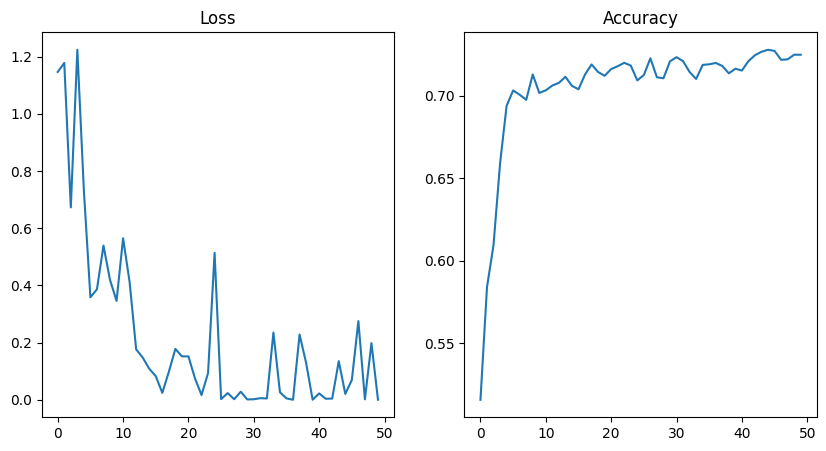

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(loss_li)
ax[0].set_title('Loss')
ax[1].plot(acc_li)
ax[1].set_title('Accuracy')
plt.show()